In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print(tf.__version__)

2.3.1


In [4]:
os.getcwd()

'/home/schoder_m/sugarcane-weed-classification/models'

In [5]:
data_dir = pathlib.Path('/home/schoder_m/crop-weed-bucket/raw_images/raw_class_images')
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Total images', image_count)

Total images 1725


In [6]:
weeds = list(data_dir.glob('weeds/*'))
# PIL.Image.open(str(weeds[2]))
sugarcane = list(data_dir.glob('sugarcane/*'))
# PIL.Image.open(str(sugarcane[1]))

## Image Pre-processing

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=235,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1725 files belonging to 2 classes.
Using 1380 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=235,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1725 files belonging to 2 classes.
Using 345 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['sugarcane', 'weeds']


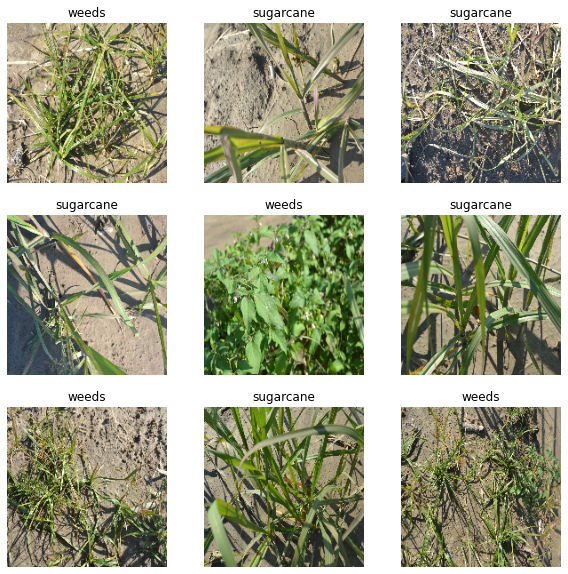

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [13]:
# Set up caching for I/O performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
# Scale input channel values from [0,255] to [0,1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Build the Model
- Basic 3-conv layer model from [TF image classification tutorial](https://www.tensorflow.org/tutorials/images/classification)
- Note model includes layers which duplicate some of the pre-processing steps above

In [16]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
44/44 [==============================] - 50s 1s/step - loss: 0.8633 - accuracy: 0.5522 - val_loss: 0.5198 - val_accuracy: 0.6841
Epoch 2/15
44/44 [==============================] - 1s 32ms/step - loss: 0.4321 - accuracy: 0.8152 - val_loss: 0.3304 - val_accuracy: 0.8493
Epoch 3/15
44/44 [==============================] - 1s 29ms/step - loss: 0.2518 - accuracy: 0.8957 - val_loss: 0.3912 - val_accuracy: 0.8580
Epoch 4/15
44/44 [==============================] - 1s 31ms/step - loss: 0.2172 - accuracy: 0.9116 - val_loss: 0.1781 - val_accuracy: 0.9304
Epoch 5/15
44/44 [==============================] - 1s 29ms/step - loss: 0.1122 - accuracy: 0.9630 - val_loss: 0.1326 - val_accuracy: 0.9565
Epoch 6/15
44/44 [==============================] - 1s 30ms/step - loss: 0.0729 - accuracy: 0.9783 - val_loss: 0.1264 - val_accuracy: 0.9594
Epoch 7/15
44/44 [==============================] - 1s 29ms/step - loss: 0.0658 - accuracy: 0.9783 - val_loss: 0.1595 - val_accuracy: 0.9478
Epoch 8/15
44/

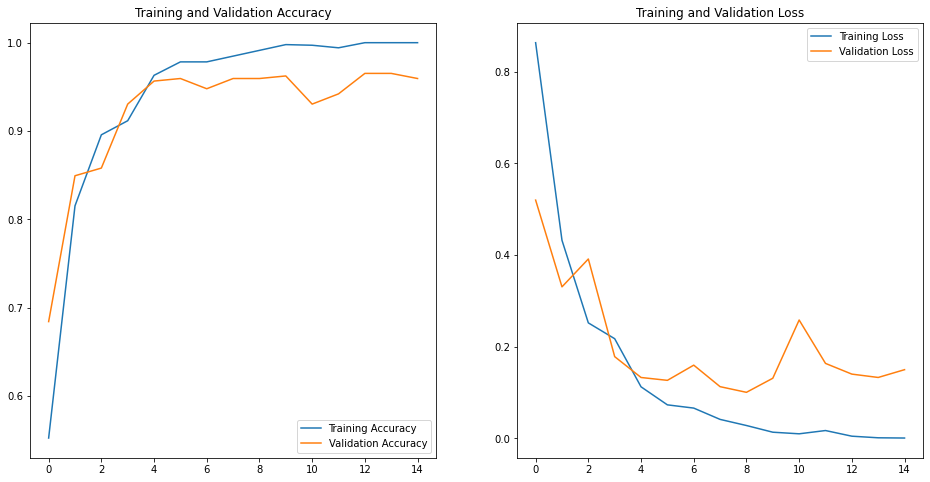

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
